In [1]:
import jax
import gymnax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini.callbacks import get_null
from rebayes_mini.methods import low_rank_last_layer as flores

In [2]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

## Can you RL?

## RL

In [4]:
gamma = 0.8

def td_mean(theta, X):
    """
    One-step-ahead predicted reward
    """

    if X.shape[0] == 2:
        # For learning
        X_curr = X[0] # (a, s)
        X_next = X[1] # (a_next, s_next)
        
        q_curr = model.apply(theta, X_curr)
    
        q_next = model.apply(theta, X_next)
    
        return q_curr - gamma * q_next
        
    else:
        # For prediction
        q = model.apply(theta, X)
        return q

    
@partial(jax.vmap, in_axes=(None, 0, None))
def vmean_fn(bel, a, s):
    X = jnp.concat([jnp.atleast_1d(a), s])
    yhat = agent.predict_fn(bel, X).squeeze()
    return yhat

## Step function

In [5]:
gamma = 0.8

def step_cartpole(state, t, agent, key_base, num_actions, eps):
    key_t = jax.random.fold_in(key_base, t)
    key_step, key_take, key_reset = jax.random.split(key_t, 3)
    
    bel, action, context, env_state = state
    
    # Take step and obtain reward(t) state(t+1)
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)
    reward_raw = jnp.copy(reward)

    # cartpole
    is_reward_neg = (env_state.time < env_params.max_steps_in_episode ) * done
    reward = reward * (1 - is_reward_neg) + -1 * is_reward_neg
        
    # Choose action (t+1)
    key_eps, key_take = jax.random.split(key_take)
    yhat = vmean_fn(bel, actions, context)
    action_new = yhat.ravel().argmax()

    eps = jnp.maximum(1e-4, 0.1 * jnp.exp(-t / 25_000)) # Half-life of 25_000

    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, num_actions)

    action_new = action_new * (1 - take_random) + action_random * take_random
    action_new = action_new.astype(int)
# 
    # pos, vel = context_new
    # reward = reward + 0.1 * abs(vel)

    
    # Update belief
    X_prev = jnp.concat([jnp.atleast_1d(action), context])
    X_next = jnp.concat([jnp.atleast_1d(action_new), context_new])
    X = jnp.stack([X_prev, X_next], axis=0)

    # first normalisation term is for action
    # norm_factors = jnp.array([1.0, 1/4.8, 1/5.0, 1/0.418, 1/5.0])
    # X = X * norm_factors[None, :]

    bel_update = agent.update(bel, reward, X)

    context_new, env_state = jax.lax.cond(done,
        lambda: env.reset(key_reset, env_params),
        lambda: (context_new, env_state)
    )

    err = reward - yhat[action]
    state_new = (bel_update, action_new, context_new, env_state)
    carry = (action_new, reward_raw, reward, done, err)
    return state_new, carry

In [6]:
gamma = 0.8

def step_mountain(state, t, agent, key_base, num_actions, eps):
    key_t = jax.random.fold_in(key_base, t)
    key_step, key_take, key_reset = jax.random.split(key_t, 3)
    
    bel, action, context, env_state = state
    
    # Take step and obtain reward(t) state(t+1)
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)
    reward_raw = jnp.copy(reward)

    # mountain car
    is_success = done * (context_new[0] >= env_params.goal_position)
    is_failure = done * (1 - is_success)
    reward = reward + 10 * is_success + -5 * is_failure
    
    # reward += 10.0 * is_success # the carrot
    # reward += -5.0 * is_failure # the stick
    # reward += 0.1 * jnp.abs(context_new[1])            # signed velocity
    # reward += -1e-3 * env_state.time          # time penalty
    
    # is_reward_plus = done * (context_new[0] >= env_params.goal_position)
    # is_failure = 1 - is_reward_plus
    # reward = reward + 10 * is_reward_plus + 0.1 * jnp.abs(context_new[1])
    # reward = reward * (1 - is_failure) + -10 * is_failure
    
    
    # Choose action (t+1)
    key_eps, key_take = jax.random.split(key_take)
    yhat = vmean_fn(bel, actions, context)
    action_new = yhat.ravel().argmax()

    eps = jnp.maximum(1e-4, 0.1 * jnp.exp(-t / 25_000)) # Half-life of 25_000

    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, num_actions)

    action_new = action_new * (1 - take_random) + action_random * take_random
    action_new = action_new.astype(int)


    # Update belief
    X_prev = jnp.concat([jnp.atleast_1d(action), context])
    X_next = jnp.concat([jnp.atleast_1d(action_new), context_new])
    X = jnp.stack([X_prev, X_next], axis=0)

    # first normalisation term is for action
    # norm_factors = jnp.array([1.0, 1 / 1.2, 1 / 0.07]) # mountain car
    # X = X * norm_factors[None, :]

    bel_update = agent.update(bel, reward, X)

    context_new, env_state = jax.lax.cond(done,
        lambda: env.reset(key_reset, env_params),
        lambda: (context_new, env_state)
    )

    err = reward - yhat[action]
    state_new = (bel_update, action_new, context_new, env_state)
    carry = (action_new, reward_raw, reward, done, err)
    return state_new, carry

In [7]:
gamma = 0.99


def get_tip_y(context, env_params):
    theta1 = context[0]
    theta2 = context[1]
    l1 = env_params.link_length_1
    l2 = env_params.link_length_2
    y_tip = -l1 * jnp.cos(theta1) - l2 * jnp.cos(theta1 + theta2)
    return y_tip



def step_acrobot(state, t, agent, key_base, num_actions, eps):
    key_t = jax.random.fold_in(key_base, t)
    key_step, key_take, key_reset = jax.random.split(key_t, 3)
    
    bel, action, context, env_state = state
    
    # Take step and obtain reward(t) state(t+1)
    context_new, env_state, reward, done, _ = env.step(key_step, env_state, action, env_params)
    reward_raw = jnp.copy(reward)

    # acrobot
    is_failure = done * (env_state.time >= env_params.max_steps_in_episode)
    is_success = done * (env_state.time < env_params.max_steps_in_episode)
    reward = reward + 10 * is_success  -2 * is_failure

    tip_y = get_tip_y(context_new, env_params)
    tip_y_normalized = (tip_y + 2.0) / 4.0
    reward = reward + 0.1 * tip_y_normalized
    
    # Choose action (t+1)
    key_eps, key_take = jax.random.split(key_take)
    yhat = vmean_fn(bel, actions, context)
    action_new = yhat.ravel().argmax()

    eps = jnp.maximum(1e-4, 0.3 * jnp.exp(-t / 100_000)) # Half-life of 25_000

    take_random = jax.random.bernoulli(key_eps, p=eps)
    action_random = jax.random.choice(key_take, num_actions)

    action_new = action_new * (1 - take_random) + action_random * take_random
    action_new = action_new.astype(int)


    # Update belief
    X_prev = jnp.concat([jnp.atleast_1d(action), context])
    X_next = jnp.concat([jnp.atleast_1d(action_new), context_new])
    X = jnp.stack([X_prev, X_next], axis=0)

    bel_update = agent.update(bel, reward, X)

    context_new, env_state = jax.lax.cond(done,
        lambda: env.reset(key_reset, env_params),
        lambda: (context_new, env_state)
    )

    err = reward - yhat[action]
    state_new = (bel_update, action_new, context_new, env_state)
    carry = (action_new, reward_raw, reward, done, err)
    return state_new, carry

# Initialise

In [8]:
key = jax.random.PRNGKey(314)
key_env, key_env_step, key_act, key_init_params, key_run = jax.random.split(key, 5)

In [9]:
# Instantiate the environment & its settings.

norm_factors = jnp.array([1/4.8, 1/5.0, 1/0.418, 1/5.0]) # cartpole
step = step_cartpole
env, env_params = gymnax.make("CartPole-v1")


# norm_factors = jnp.array([1 / 1.2, 1 / 0.07]) # mountain car
# step = step_mountain
# env, env_params = gymnax.make("MountainCar-v0")


# norm_factors = jnp.array([1, 1, 1, 1, 1/4.0, 1/9.0]) # acrobot
# step = step_acrobot
# env, env_params = gymnax.make("Acrobot-v1")

In [10]:
# Reset the environment.
context_init, env_state_init = env.reset(key_env, env_params)

# Sample a random action.
action_init = env.action_space(env_params).sample(key_act)
context_init

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Array([0.04561364, 0.04379877, 0.00540032, 0.01181908], dtype=float32)

## Model setup

In [11]:
class MLP(nn.Module):
    num_actions: int
    norm_factors: jax.Array

    @nn.compact
    def __call__(self, x):
        x_action = x[..., 0].astype(jnp.int32)
        x_state = x[..., 1:] * self.norm_factors

        x_state = nn.Dense(50)(x_state)
        x_state = nn.elu(x_state)
        # x_state = jnp.sin(x_state)
        x_state = nn.Dense(50)(x_state)
        x_state = nn.elu(x_state)

        x = nn.Dense(self.num_actions, name="last_layer")(x_state)
        return jnp.atleast_1d(x[x_action])

In [12]:
# Initialise agent
X = jnp.concat([jnp.atleast_1d(action_init), context_init])
dim_state = len(X)
model = MLP(num_actions=env.num_actions, norm_factors=norm_factors)
params_init = model.init(key_init_params, X)

# context, state, reward, done, _ = env.step(key_env_step, env_state_init, action_init, env_params)
# action = env.action_space(env_params).sample(key_act)

actions = jnp.arange(env.num_actions)

## Testing methods

In [13]:
from optax import adamw
from rebayes_mini.methods import replay_sgd
from vbll_fifo import FifoLaplaceDiag
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_filter as lofi

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FLoRES

In [64]:
res_experiment = {}

In [65]:
agent = flores.LowRankLastLayer(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 1.0,
    rank=50,
    dynamics_hidden=1e-6,
    dynamics_last=1e-6
)
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)

In [66]:
%%time
u_init = (bel_init, action_init, context_init, env_state_init)
steps = 200_000


eps = None # this is a dummy for now
# eps = 0.01

_step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
res = jax.lax.scan(_step, u_init, jnp.arange(steps))
(bel_final, *_, env_state_final), hist = res
hist = jax.tree.map(np.array, hist)
(actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
rewards = jax.block_until_ready(rewards)

res_experiment["FLoRES"] = {
    "rewards": rewards,
    "rewards_raw": rewards_raw,
    "done_hist": done_hist
}

CPU times: user 3.15 s, sys: 117 ms, total: 3.27 s
Wall time: 1min 4s


In [67]:
res_experiment = jax.tree.map(np.array, res_experiment)

In [68]:
pd.Series(actions_hist).value_counts()

1    101853
0     98147
Name: count, dtype: int64

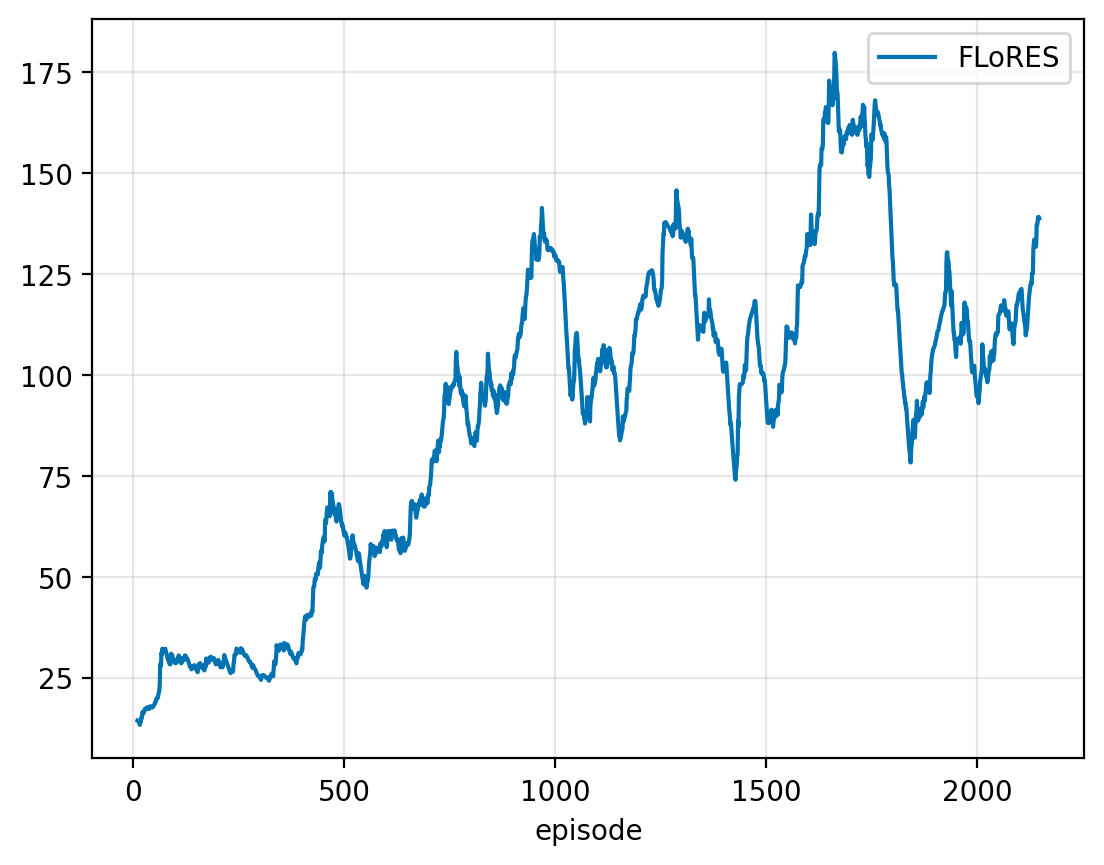

In [69]:
min_periods = 10
for experiment in res_experiment:

    df = pd.DataFrame(res_experiment[experiment])
    df["episode"] = df["done_hist"].cumsum()
    # df.groupby("episode")["rewards"].sum().iloc[1:-1].plot()
    # df.groupby("episode")["rewards_raw"].sum().iloc[1:-1].ewm(span=10).mean().plot()
    (
        df
        .groupby("episode")["rewards_raw"].sum().iloc[1:-1]
        .ewm(span=100, min_periods=min_periods).mean()
        .plot(label=experiment)
    )
    plt.legend()
# plt.xlim(0, 2000)
plt.grid(alpha=0.3)

### Multiple runs

In [71]:
agent = flores.LowRankLastLayer(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 1.0,
    rank=50,
    dynamics_hidden=1e-6,
    dynamics_last=1e-6
)

In [72]:
def run(key, steps=200_000):
    key_init_params, key_run = jax.random.split(key)
    
    params_init = model.init(key_init_params, X)
    bel_init = agent.init_bel(params_init, low_rank_diag=True, cov_hidden=1.0, cov_last=1.0)
    u_init = (bel_init, action_init, context_init, env_state_init)
    
    eps = None # this is a dummy for now
    
    _step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
    res = jax.lax.scan(_step, u_init, jnp.arange(steps))
    (bel_final, *_, env_state_final), hist = res
    
    (actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
    
    res = {
        "rewards": rewards,
        "rewards_raw": rewards_raw,
        "done_hist": done_hist
    }
    return res

In [73]:
%%time
key = jax.random.PRNGKey(271)
keys = jax.random.split(key, 10)
res = jax.vmap(run)(keys)
res = jax.block_until_ready(res)
res = jax.tree.map(np.array, res)

CPU times: user 6.19 s, sys: 333 ms, total: 6.52 s
Wall time: 4min 36s


In [74]:
res["episode"] = res["done_hist"].cumsum(axis=1)

In [75]:
def reward_by_episode(res):
    return jax.ops.segment_sum(res["rewards"], res["episode"], num_segments=2000)

In [76]:
rewards_hilofi = jax.vmap(reward_by_episode, out_axes=1)(res)
rewards_hilofi = pd.DataFrame(rewards_hilofi).replace(0, np.nan)

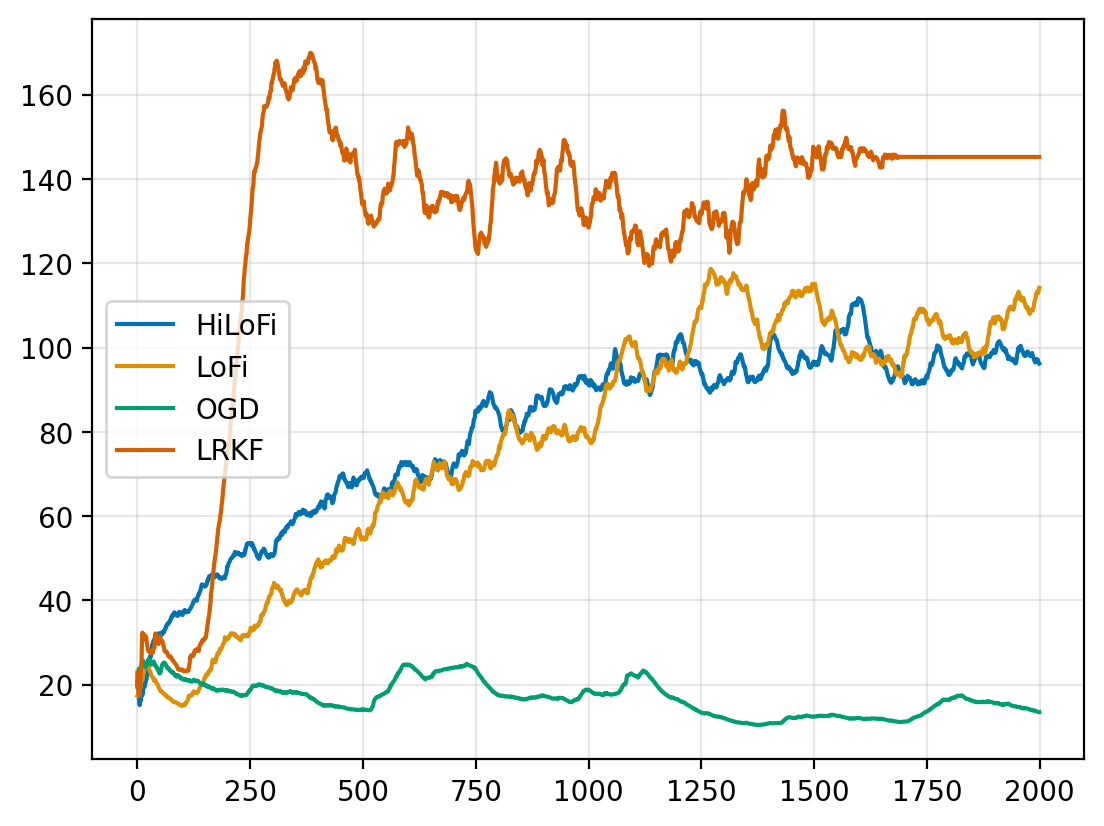

In [78]:
rewards_hilofi.ewm(span=100).mean().mean(axis=1).plot(label="HiLoFi")
rewards_lofi.ewm(span=100).mean().mean(axis=1).plot(label="LoFi")
rewards_lrkf.ewm(span=100).mean().mean(axis=1).plot(label="OGD")
rewards_sgd.ewm(span=100).mean().mean(axis=1).plot(label="LRKF")
plt.legend()
plt.grid(alpha=0.3)

<Axes: >

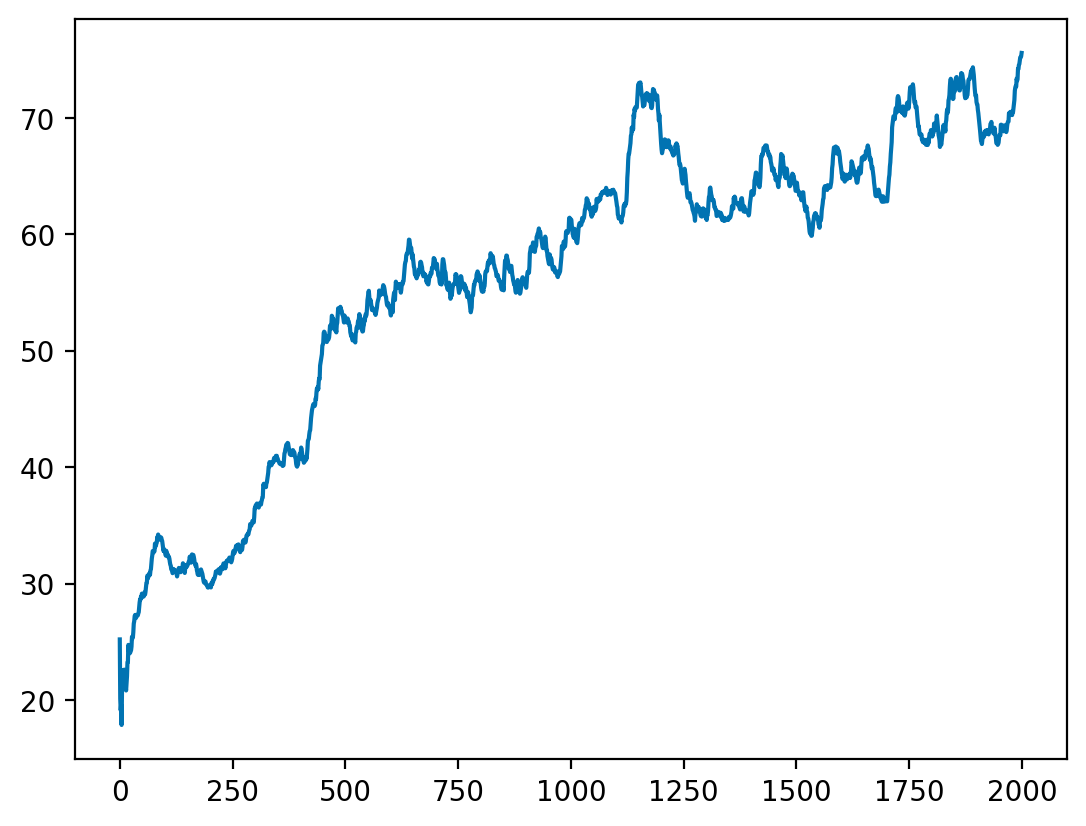

In [20]:
mean = rewards_hilofi.ewm(span=100).mean().mean(axis=1)
std = rewards_hilofi.ewm(span=100).std().mean(axis=1)
mean.plot()

# Online SGD 

In [181]:
def lossfn(params, counter, X, y, apply_fn):
    yhat = jax.vmap(apply_fn, in_axes=(None, 0))(params, X)
    err = jnp.power(yhat.squeeze() - y.squeeze(), 2)
    return (err * counter).sum() / counter.sum()

In [182]:
# Replay SGD
agent = replay_sgd.FifoSGD(
    apply_fn=td_mean,
    lossfn=lossfn,
    tx=adamw(learning_rate=1e-4),
    # dim_features=(2, 3),
    dim_features=(2, dim_state),
    dim_output=1,
    n_inner=1,
    buffer_size=50,
)

bel_init = agent.init_bel(params_init)

In [23]:
%%time
u_init = (bel_init, action_init, context_init, env_state_init)
steps = 200_000

eps = None # this is a dummy for now

_step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
res = jax.lax.scan(_step, u_init, jnp.arange(steps))
(bel_final, *_, env_state_final), hist = res
hist = jax.tree.map(np.array, hist)
(actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
rewards = jax.block_until_ready(rewards)


res_experiment["adamw"] = {
    "rewards": rewards,
    "rewards_raw": rewards_raw,
    "done_hist": done_hist
}

CPU times: user 2.96 s, sys: 222 ms, total: 3.19 s
Wall time: 4min


### Multiple runs

In [21]:
def lossfn(params, counter, X, y, apply_fn):
    yhat = jax.vmap(apply_fn, in_axes=(None, 0))(params, X)
    err = jnp.power(yhat.squeeze() - y.squeeze(), 2)
    return (err * counter).sum() / counter.sum()

In [22]:
# Replay SGD
agent = replay_sgd.FifoSGD(
    apply_fn=td_mean,
    lossfn=lossfn,
    tx=adamw(learning_rate=1e-4),
    # dim_features=(2, 3),
    dim_features=(2, dim_state),
    dim_output=1,
    n_inner=1,
    buffer_size=50,
)

In [23]:
def run(key, steps=200_000):
    key_init_params, key_run = jax.random.split(key)
    
    params_init = model.init(key_init_params, X)
    bel_init = agent.init_bel(params_init)
    u_init = (bel_init, action_init, context_init, env_state_init)
    
    eps = None # this is a dummy for now
    
    _step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
    res = jax.lax.scan(_step, u_init, jnp.arange(steps))
    (bel_final, *_, env_state_final), hist = res
    
    (actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
    
    res = {
        "rewards": rewards,
        "rewards_raw": rewards_raw,
        "done_hist": done_hist
    }
    return res

In [ ]:
%%time
key = jax.random.PRNGKey(271)
keys = jax.random.split(key, 10)
res = jax.vmap(run)(keys)
res = jax.tree.map(np.array, res)

In [ ]:
res["episode"] = res["done_hist"].cumsum(axis=1)

In [ ]:
def reward_by_episode(res):
    return jax.ops.segment_sum(res["rewards"], res["episode"], num_segments=2000)

In [ ]:
rewards_sgd = jax.vmap(reward_by_episode, out_axes=1)(res)
rewards_sgd = pd.DataFrame(rewards_sgd).replace(0, np.nan)

In [ ]:
mean = rewards_sgd.ewm(span=100).mean().mean(axis=1)
mean.plot()

## LKRF

In [24]:
# LRKF
agent = lrkf.LowRankCovarianceFilter(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 2.0,
    rank=50,
    dynamics_covariance=1e-6
)
bel_init = agent.init_bel(params_init, low_rank_diag=True, cov=1.0)

In [25]:
%%time
u_init = (bel_init, action_init, context_init, env_state_init)
steps = 200_000

eps = None # this is a dummy for now

_step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
res = jax.lax.scan(_step, u_init, jnp.arange(steps))
(bel_final, *_, env_state_final), hist = res
hist = jax.tree.map(np.array, hist)
(actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
rewards = jax.block_until_ready(rewards)


res_experiment["LRKF"] = {
    "rewards": rewards,
    "rewards_raw": rewards_raw,
    "done_hist": done_hist
}

CPU times: user 3.1 s, sys: 96.6 ms, total: 3.2 s
Wall time: 56.3 s


### Multiple runs

In [ ]:
# LRKF
agent = lrkf.LowRankCovarianceFilter(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 2.0,
    rank=50,
    dynamics_covariance=1e-6
)

In [ ]:
def run(key, steps=200_000):
    key_init_params, key_run = jax.random.split(key)
    
    params_init = model.init(key_init_params, X)
    bel_init = agent.init_bel(params_init, low_rank_diag=True, cov=1.0)
    u_init = (bel_init, action_init, context_init, env_state_init)
    
    eps = None # this is a dummy for now
    
    _step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
    res = jax.lax.scan(_step, u_init, jnp.arange(steps))
    (bel_final, *_, env_state_final), hist = res
    
    (actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
    
    res = {
        "rewards": rewards,
        "rewards_raw": rewards_raw,
        "done_hist": done_hist
    }
    return res

In [ ]:
%%time
key = jax.random.PRNGKey(271)
keys = jax.random.split(key, 10)
res = jax.vmap(run)(keys)
res = jax.tree.map(np.array, res)

In [ ]:
res["episode"] = res["done_hist"].cumsum(axis=1)

In [ ]:
def reward_by_episode(res):
    return jax.ops.segment_sum(res["rewards"], res["episode"], num_segments=2000)

In [ ]:
rewards_lrkf = jax.vmap(reward_by_episode, out_axes=1)(res)
rewards_lrkf = pd.DataFrame(rewards_lrkf).replace(0, np.nan)

In [ ]:
mean = rewards_lrkf.ewm(span=100).mean().mean(axis=1)
mean.plot()

## LoFi

In [26]:
# LoFi
agent = lofi.LowRankPrecisionFilter(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 2.0,
    rank=50,
    dynamics_covariance=1e-6
)
bel_init = agent.init_bel(params_init, cov=1.0)

In [27]:
%%time
u_init = (bel_init, action_init, context_init, env_state_init)
steps = 200_000

eps = None # this is a dummy for now

_step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
res = jax.lax.scan(_step, u_init, jnp.arange(steps))
(bel_final, *_, env_state_final), hist = res
hist = jax.tree.map(np.array, hist)
(actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
rewards = jax.block_until_ready(rewards)


res_experiment["LoFi"] = {
    "rewards": rewards,
    "rewards_raw": rewards_raw,
    "done_hist": done_hist
}

CPU times: user 4.43 s, sys: 219 ms, total: 4.65 s
Wall time: 1min 51s


### Multiple runs

In [ ]:
# LoFi
agent = lofi.LowRankPrecisionFilter(
    mean_fn=td_mean,
    cov_fn=lambda x: jnp.eye(1) * 2.0,
    rank=50,
    dynamics_covariance=1e-6
)

In [ ]:
def run(key, steps=200_000):
    key_init_params, key_run = jax.random.split(key)
    
    params_init = model.init(key_init_params, X)
    bel_init = agent.init_bel(params_init, cov=1.0)
    u_init = (bel_init, action_init, context_init, env_state_init)
    
    eps = None # this is a dummy for now
    
    _step = partial(step, agent=agent, key_base=key_run, num_actions=env.num_actions, eps=eps)
    res = jax.lax.scan(_step, u_init, jnp.arange(steps))
    (bel_final, *_, env_state_final), hist = res
    
    (actions_hist, rewards_raw, rewards, done_hist, err_hist) = hist
    
    res = {
        "rewards": rewards,
        "rewards_raw": rewards_raw,
        "done_hist": done_hist
    }
    return res

In [ ]:
%%time
key = jax.random.PRNGKey(271)
keys = jax.random.split(key, 10)
res = jax.vmap(run)(keys)
res = jax.tree.map(np.array, res)

In [ ]:
res["episode"] = res["done_hist"].cumsum(axis=1)

In [ ]:
def reward_by_episode(res):
    return jax.ops.segment_sum(res["rewards"], res["episode"], num_segments=2000)

In [ ]:
rewards_lofi = jax.vmap(reward_by_episode, out_axes=1)(res)
rewards_lofi = pd.DataFrame(rewards_lofi).replace(0, np.nan)

In [ ]:
mean = rewards_lofi.ewm(span=100).mean().mean(axis=1)
mean.plot()

## Results

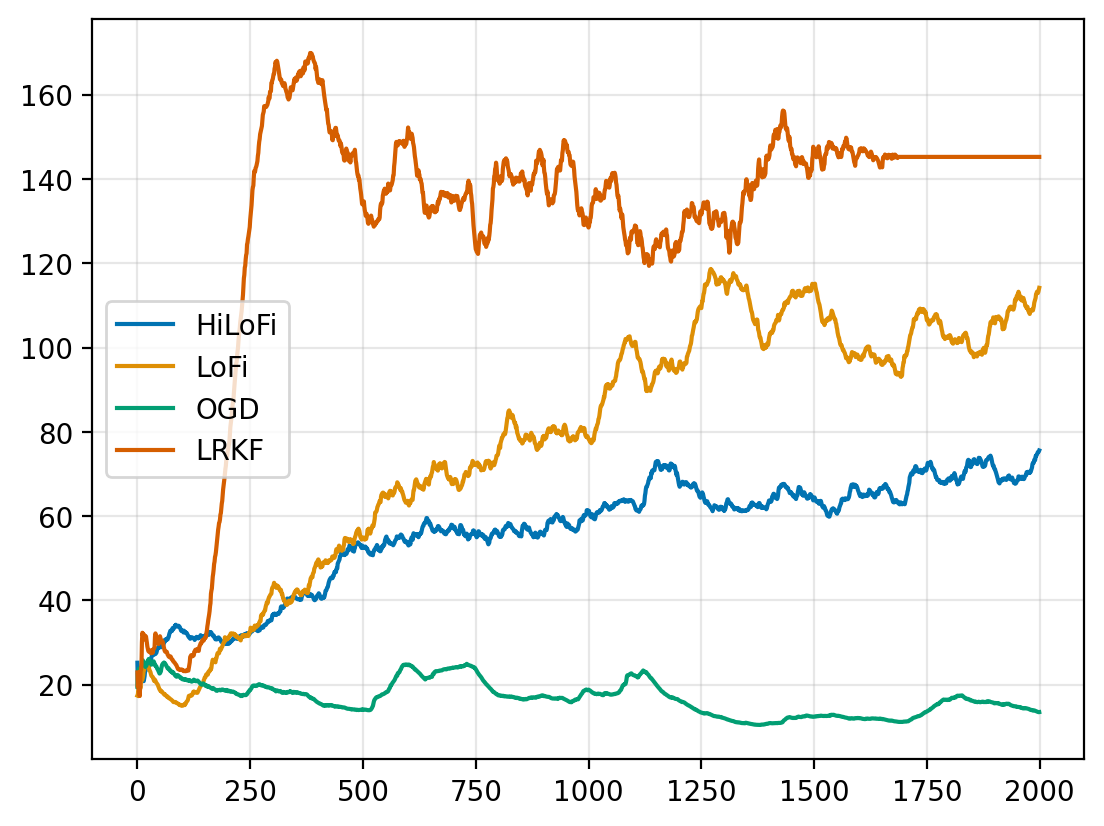

In [70]:
rewards_hilofi.ewm(span=100).mean().mean(axis=1).plot(label="HiLoFi")
rewards_lofi.ewm(span=100).mean().mean(axis=1).plot(label="LoFi")
rewards_lrkf.ewm(span=100).mean().mean(axis=1).plot(label="OGD")
rewards_sgd.ewm(span=100).mean().mean(axis=1).plot(label="LRKF")
plt.legend()
plt.grid(alpha=0.3)

In [28]:
res_experiment = jax.tree.map(np.array, res_experiment)

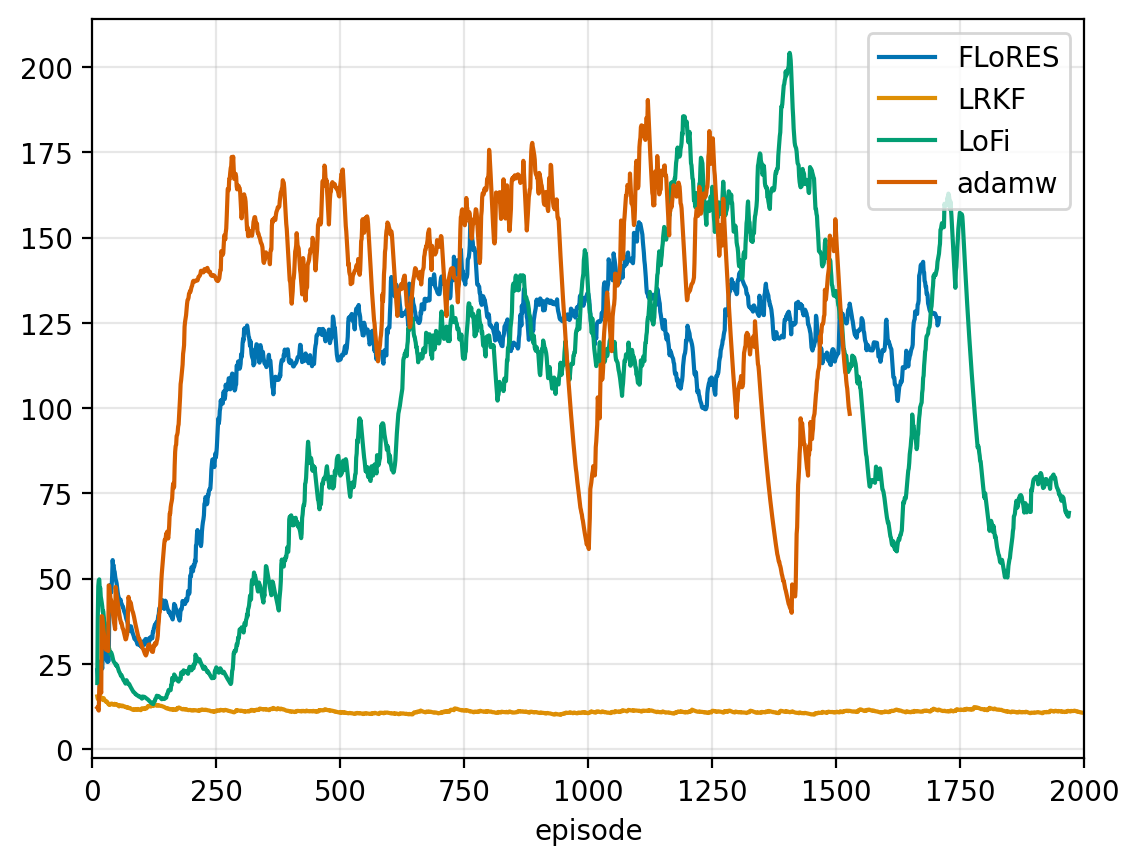

In [29]:
min_periods = 10
for experiment in res_experiment:

    df = pd.DataFrame(res_experiment[experiment])
    df["episode"] = df["done_hist"].cumsum()
    # df.groupby("episode")["rewards"].sum().iloc[1:-1].plot()
    # df.groupby("episode")["rewards_raw"].sum().iloc[1:-1].ewm(span=10).mean().plot()
    (
        df
        .groupby("episode")["rewards"].sum().iloc[1:-1]
        .ewm(span=100, min_periods=min_periods).mean()
        .plot(label=experiment)
    )
    plt.legend()
plt.xlim(0, 2000)
plt.grid(alpha=0.3)